# UE20CS334 - Natural Language Processing - Project
## Team 03
## Literary device Identification - Personification

### Team Members

| Name                  | SRN           |
| --------------------- | ------------- |
| Ajay Anil Kumar       | PES2UG20CS028 |
| C V Eswar Sai Reddy   | PES2UG20CS096 |
| Rudra Narayan Samanta | PES2UG20CS286 |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import traceback
import json
from nltk.corpus import wordnet as wn
import pandas as pd
import json
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import metrics
import pickle
from tensorflow import keras
from nltk.corpus import wordnet as wn
import os
import spacy
from spacy import displacy
from nltk.tag import _get_tagger, _pos_tag
import tqdm
from nltk import pos_tag
disable = ['ner', 'senter']
nlp = spacy.load("en_core_web_sm", disable = disable)
from nvp import extract_pair_from_sentence
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, accuracy_score , f1_score
main_process = __name__ == '__main__'

In [2]:
inanimate_models_dir = "personification/save_inanimate_models"
nvpair_models_dir = "personification/save_nvpair_models/"

### Declaring basic functions

In [3]:
def train_model(model, x_train, y_train):
    '''
    Function to train model.

    Trains the model and returns the model and history.
    '''
    print("Training", model)
    history = model.fit(x_train, y_train)
    return model, history

In [4]:
def plot_confusion_matrix(model, actual, predicted):
    '''
    Given actual values and predicted values plots the confusion matrix
    '''
    predicted = predicted.flatten()
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.title(model)
    plt.show()


In [5]:
def calc_accuracy(model, x_test, y_test, show_confusion_matrix = False):
    '''
    Given model, train data and test data reutrns the predictions and accuracy'''
    try:
        print(model)
        predictions = model.predict(x_test)
        modulator = lambda num: 0 if num < 0.5 else 1
        modulator = np.vectorize(modulator)
        predictions = modulator(predictions)
        predictions = predictions.flatten()
        y_test = y_test.flatten()
        y_test.reshape(y_test.size)
        results = predictions == y_test
        f_res = list(results)
        total = len(f_res)
        positives = f_res.count(True)
        if show_confusion_matrix:
            plot_confusion_matrix(str(model), y_test, predictions)
        return predictions, positives / total
    except:
        print(traceback.format_exc())

In [6]:
def get_word_types(word, noun_only = True):
    # print(word, type(word))
    synsets = wn.synsets(str(word))
    word_types = []
    if noun_only:
        for synset in synsets:
            lexname = synset.lexname()
            pos, word_type = lexname.split(".")
            if pos == 'noun':
                word_types.append(word_type)
    else:
        for synset in synsets:
            lexname = synset.lexname()
            pos, word_type = lexname.split(".")
            word_types.append(word_type)
    return set(word_types)

In [7]:
class ensemble_classification_predictor:
    def __init__(self, models):
        if type(models) == dict:
            self.models = list(models.values())
        else:
            self.models = models

    def predict_ensemble(self, predictions):
        true_count = 0
        for prediction in predictions:
            if prediction:
                true_count += 1
        if (true_count/len(predictions)) > 0.5:
            return True
        else:
            return False
    
    def fix_predictions(self, predictions):
        '''
        if values are in range 0 to 1 - shifts to True or False
        '''
        predictions = np.array(predictions)
        fixer = np.vectorize(lambda num: True if (num == True or num > 0.5) else False)
        predictions = fixer(predictions)
        return predictions
    
    def predict(self, x_data):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(x_data))
        for num in range(len(predictions)):
            predictions[num] = self.fix_predictions(predictions[num])
        predictions_from_models = []
        for num in range(len(predictions[0])):
            predictions_from_models.append([arr[num] for arr in predictions])
        predictions_final = [
            self.predict_ensemble(row) for row in predictions_from_models
        ]
        return predictions_final


In [8]:
def precision_recall_accuracy_f1(actual, predicted):
    results = precision_score(actual, predicted), recall_score(actual, predicted), accuracy_score(actual, predicted), f1_score(actual, predicted)
    print(list(zip(['precision:', 'recall:', 'accuracy:', 'f1_score:'], results)))
    return results

## 1. Training model to identify inanimate words

### Generating dataset to train models to identify animate and inanimate nouns

### Loading different animate words and inanimate words

In [9]:
animates = open("personification/store_animate_words.txt", encoding = 'utf-8')
inanimates = open("personification/store_inanimate_words.txt", encoding = 'utf-8')
animates = [line.strip() for line in animates]
inanimates = [line.strip() for line in inanimates]
print(f"{len(animates)} Animates and {len(inanimates)} Inanimates Found")

696 Animates and 684 Inanimates Found


In [10]:
animates_word_types = [(word, get_word_types(word)) for word in animates]
inanimates_word_types = [(word, get_word_types(word)) for word in inanimates]

In [11]:
all_types = {}
for pair in animates_word_types + inanimates_word_types:
    for w_type in pair[1]:
        if w_type in all_types:
            all_types[w_type] += 1
        else:
            all_types[w_type] = 1
print(f"Total {len(all_types)} Types Found")
print(json.dumps(all_types))
all_types = [(key, all_types[key]) for key in all_types]
all_types.sort(key = lambda elem: elem[1], reverse = True)
print(len(all_types), all_types)

Total 26 Types Found
{"person": 551, "animal": 350, "food": 68, "group": 72, "time": 11, "artifact": 663, "cognition": 50, "Tops": 8, "attribute": 46, "act": 133, "communication": 127, "location": 41, "substance": 88, "object": 80, "plant": 31, "body": 46, "state": 41, "quantity": 67, "event": 44, "possession": 18, "shape": 40, "phenomenon": 17, "feeling": 5, "process": 7, "relation": 6, "motive": 1}
26 [('artifact', 663), ('person', 551), ('animal', 350), ('act', 133), ('communication', 127), ('substance', 88), ('object', 80), ('group', 72), ('food', 68), ('quantity', 67), ('cognition', 50), ('attribute', 46), ('body', 46), ('event', 44), ('location', 41), ('state', 41), ('shape', 40), ('plant', 31), ('possession', 18), ('phenomenon', 17), ('time', 11), ('Tops', 8), ('process', 7), ('relation', 6), ('feeling', 5), ('motive', 1)]


In [12]:
columns = ["word"] + [tp[0] for tp in all_types] + ["class_type"]

In [13]:
num_types = len(all_types)      
# all_types

In [14]:
animates_rows = [
    [
        1 if all_types[num][0] in animate[1] else 0
            for num in range(num_types)
    ]
    for animate in animates_word_types
]

final_animate_rows = [
    [animates_word_types[num][0]] + animates_rows[num] + [0]
        for num in range(len(animates_rows))
]

In [15]:
inanimates_rows = [
    [
        1 if all_types[num][0] in inanimate[1] else 0
            for num in range(num_types)
    ]
    for inanimate in inanimates_word_types
]

final_inanimate_rows = [
    [inanimates_word_types[num][0]] + inanimates_rows[num] + [1]
        for num in range(len(inanimates_rows))
]

In [16]:
final_length = min(len(final_animate_rows), len(final_inanimate_rows))

In [17]:
final_animates = random.sample(final_animate_rows, final_length)
final_inanimates = random.sample(final_inanimate_rows, final_length)

In [18]:
len(final_animates), len(final_inanimate_rows)

(684, 684)

In [19]:
df_animates = pd.DataFrame(
    final_animates,
    columns = columns
)

df_inanimates = pd.DataFrame(
    final_inanimates,
    columns = columns
)

In [20]:
df_animates.columns

Index(['word', 'artifact', 'person', 'animal', 'act', 'communication',
       'substance', 'object', 'group', 'food', 'quantity', 'cognition',
       'attribute', 'body', 'event', 'location', 'state', 'shape', 'plant',
       'possession', 'phenomenon', 'time', 'Tops', 'process', 'relation',
       'feeling', 'motive', 'class_type'],
      dtype='object')

In [21]:
df_animates.describe()

,artifact,person,animal,act,communication,substance,object,group,food,quantity,...,plant,possession,phenomenon,time,Tops,process,relation,feeling,motive,class_type
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,...,684.000000,684.000000,684.000000,684.000000,684.000000,684.0,684.0,684.000000,684.0,684.0
mean,0.106725,0.644737,0.450292,0.032164,0.051170,0.035088,0.027778,0.019006,0.067251,0.010234,...,0.016082,0.002924,0.004386,0.001462,0.005848,0.0,0.0,0.002924,0.0,0.0
std,0.308989,0.478943,0.497887,0.176564,0.220505,0.184136,0.164456,0.136645,0.250640,0.100718,...,0.125883,0.054034,0.066130,0.038236,0.076304,0.0,0.0,0.054034,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,0.0


In [22]:
df_inanimates.columns

Index(['word', 'artifact', 'person', 'animal', 'act', 'communication',
       'substance', 'object', 'group', 'food', 'quantity', 'cognition',
       'attribute', 'body', 'event', 'location', 'state', 'shape', 'plant',
       'possession', 'phenomenon', 'time', 'Tops', 'process', 'relation',
       'feeling', 'motive', 'class_type'],
      dtype='object')

In [23]:
df_inanimates.describe()

,artifact,person,animal,act,communication,substance,object,group,food,quantity,...,plant,possession,phenomenon,time,Tops,process,relation,feeling,motive,class_type
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,...,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.0
mean,0.861111,0.152047,0.052632,0.160819,0.133041,0.093567,0.089181,0.086257,0.032164,0.087719,...,0.029240,0.023392,0.020468,0.014620,0.005848,0.010234,0.008772,0.004386,0.001462,1.0
std,0.346084,0.359329,0.223460,0.367632,0.339868,0.291439,0.285214,0.280949,0.176564,0.283093,...,0.168601,0.151255,0.141698,0.120113,0.076304,0.100718,0.093315,0.066130,0.038236,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [24]:
final_all = final_animates + final_inanimates
random.shuffle(final_all)

In [25]:
df_all = pd.DataFrame(
    final_all,
    columns=columns
)

In [26]:
df_all

,word,artifact,person,animal,act,communication,substance,object,group,food,...,plant,possession,phenomenon,time,Tops,process,relation,feeling,motive,class_type
0,Advertiser,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,gorilla,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Whisk,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,T-shirt,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Alarm,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,dragon,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1364,screen,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1365,Filmmaker,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1366,Mallet,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
df_all.describe()

,artifact,person,animal,act,communication,substance,object,group,food,quantity,...,plant,possession,phenomenon,time,Tops,process,relation,feeling,motive,class_type
count,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,...,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000,1368.000000
mean,0.483918,0.398392,0.251462,0.096491,0.092105,0.064327,0.058480,0.052632,0.049708,0.048977,...,0.022661,0.013158,0.012427,0.008041,0.005848,0.005117,0.004386,0.003655,0.000731,0.500000
std,0.499924,0.489746,0.434012,0.295372,0.289280,0.245425,0.234734,0.223379,0.217420,0.215898,...,0.148874,0.113992,0.110822,0.089343,0.076276,0.071376,0.066105,0.060368,0.027037,0.500183
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
df_animates.to_csv("personification/animates.csv")
df_inanimates.to_csv("personification/inanimates.csv")
df_all.to_csv("personification/all_animate_inanimate.csv")

### Loading the dataset

In [29]:
df = pd.read_csv("personification/all_animate_inanimate.csv")

### Splitting the dataset into train and test data

In [30]:
x = df.columns[2:-1]
y = ['class_type']
df_input_attributes = df[x]
df_output_attribute = df[y]
x

Index(['artifact', 'person', 'animal', 'act', 'communication', 'substance',
       'object', 'group', 'food', 'quantity', 'cognition', 'attribute', 'body',
       'event', 'location', 'state', 'shape', 'plant', 'possession',
       'phenomenon', 'time', 'Tops', 'process', 'relation', 'feeling',
       'motive'],
      dtype='object')

In [31]:
x_train, x_test, y_train, y_test = train_test_split(
    df_input_attributes,
    df_output_attribute,
    shuffle = True,
    test_size = 0.3
)
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((957, 26), (957, 1), (411, 26), (411, 1))

### Declaring all models

In [32]:
model_nn = Sequential()
model_nn.add(Dense(26 * 16, input_shape = (len(x),), activation = 'relu'))
model_nn.add(Dense(26 * 16, activation = 'relu'))
model_nn.add(Dense(26 * 8, activation = 'relu'))
model_nn.add(Dense(26 * 4, activation = 'relu'))
# model_nn.add(Dropout(0.3))
model_nn.add(Dense(26 * 2, activation = 'relu'))
model_nn.add(Dense(26, activation = 'relu'))
# model_nn.add(Dropout(0.4))
model_nn.add(Dense(1, activation = 'sigmoid'))
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
all_models = {
    # "LinearRegression": LinearRegression(fit_intercept=True, normalize=True, n_jobs=1, copy_X=True),
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "SVC": SVC(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LinearSVC": LinearSVC(),
    "Sequential": model_nn
}

### Training the models

In [34]:
trained_all = {

}

for model in all_models:
    try:
        if model == "Sequential":
            trained_model = all_models[model]
            history = trained_model.fit(x_train, y_train, epochs = 6)
        else:
            trained_model, history = train_model(all_models[model], x_train, y_train)
        trained_all[model] = {
            'model': trained_model,
            'history': history,
        }
    except:
        print("ERROR")
        print(traceback.format_exc())

Training LogisticRegression()
Training DecisionTreeClassifier()
Training RandomForestClassifier()
Training SVC()
Training KNeighborsClassifier()
Training LinearSVC()
Epoch 1/6
30/30 [==============================] - 2s 6ms/step - loss: 0.3300 - accuracy: 0.9060
Epoch 2/6
30/30 [==============================] - 0s 5ms/step - loss: 0.2347 - accuracy: 0.9342
Epoch 3/6
30/30 [==============================] - 0s 5ms/step - loss: 0.1862 - accuracy: 0.9300
Epoch 4/6
30/30 [==============================] - 0s 5ms/step - loss: 0.1838 - accuracy: 0.9363
Epoch 5/6
30/30 [==============================] - 0s 5ms/step - loss: 0.1540 - accuracy: 0.9457
Epoch 6/6
30/30 [==============================] - 0s 5ms/step - loss: 0.1353 - accuracy: 0.9488


In [35]:
[model['model'] for model in trained_all.values()]

[LogisticRegression(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 SVC(),
 KNeighborsClassifier(),
 LinearSVC(),

LogisticRegression()


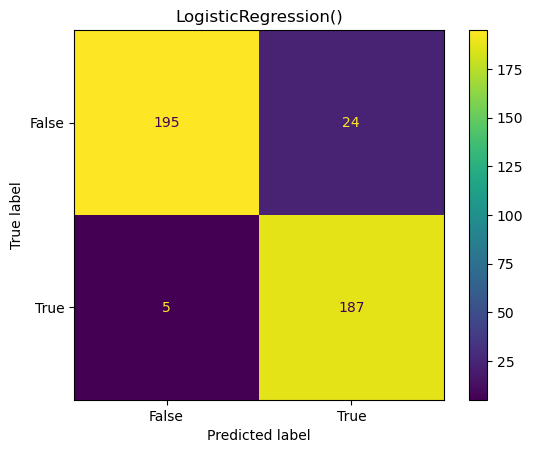

LogisticRegression            : 0.9294403892944039
DecisionTreeClassifier()


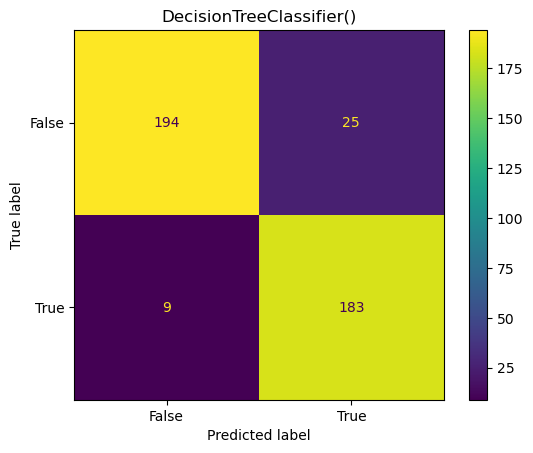

DecisionTreeClassifier        : 0.9172749391727494
RandomForestClassifier()


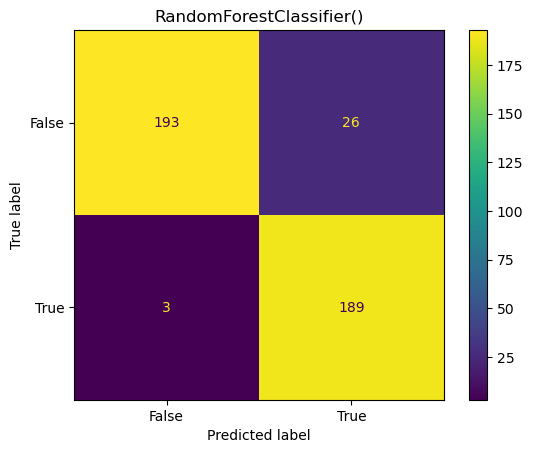

RandomForestClassifier        : 0.9294403892944039
SVC()


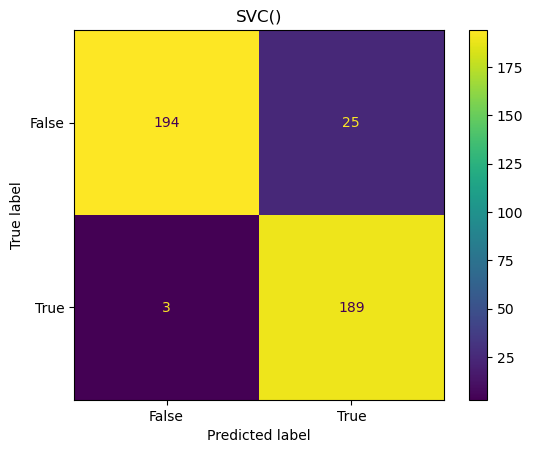

SVC                           : 0.9318734793187348
KNeighborsClassifier()


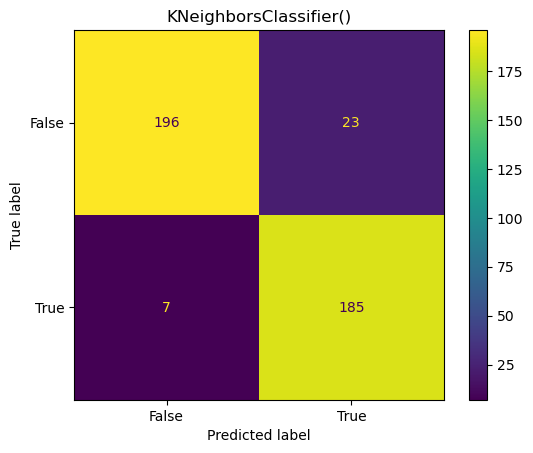

KNeighborsClassifier          : 0.927007299270073
LinearSVC()


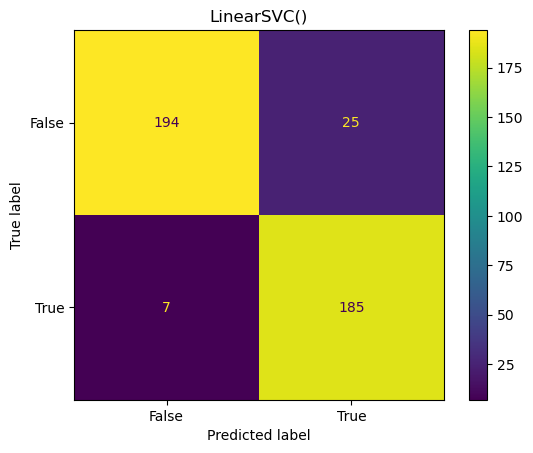

LinearSVC                     : 0.9221411192214112
13/13 [==============================] - 0s 2ms/step


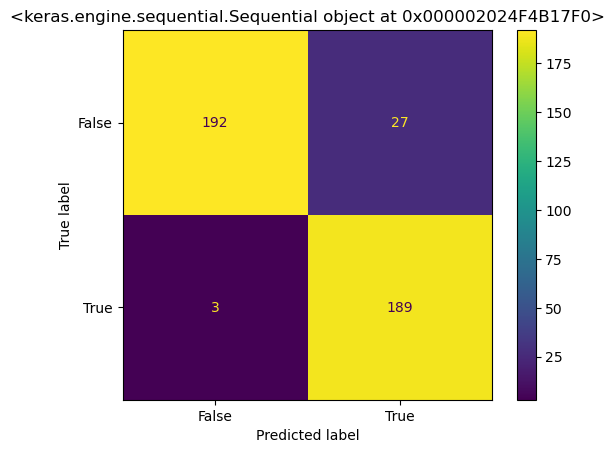

Sequential                    : 0.927007299270073
13/13 [==============================] - 0s 2ms/step
Ensemble - Mix of all models - 0.9343065693430657


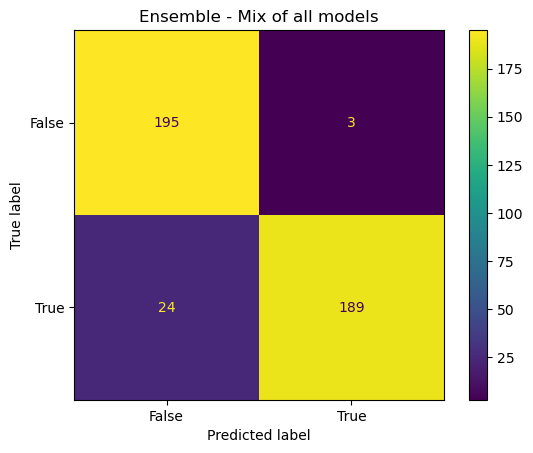

In [36]:
for model in trained_all:
    predictions, accuracy = calc_accuracy(trained_all[model]['model'], x_test, y_test, show_confusion_matrix = True)
    print(f"{model:30s}: {accuracy}")

predictor = ensemble_classification_predictor([model['model'] for model in trained_all.values()])
predictions = predictor.predict(x_test)
actual = np.array(y_test).flatten()
predictions = np.array(predictions).flatten()
results = predictions == actual
count_right = list(results).count(True)
print(f"Ensemble - Mix of all models - {count_right/len(predictions)}")
plot_confusion_matrix("Ensemble - Mix of all models", predictions, y_test)
    

In [37]:
model_files = []
for model in trained_all:
    if model != "Sequential":
        pickle.dump(trained_all[model]['model'], open(f"{inanimate_models_dir}/{model}.pickle", "wb"))
        model_files.append(model)
trained_all['Sequential']['model'].save(f"{inanimate_models_dir}/Sequential")

INFO:tensorflow:Assets written to: personification/save_inanimate_models/Sequential\assets


In [38]:
inanimate_models = {model: pickle.load(open(f"{inanimate_models_dir}/{model}.pickle", "rb")) for model in [fname.replace('.pickle', '') for fname in os.listdir(inanimate_models_dir) if os.path.isfile(os.path.join(inanimate_models_dir, fname))]}
inanimate_models['Sequential'] = keras.models.load_model(f"{inanimate_models_dir}/Sequential")

In [39]:
class personification_functions:

    def __init__(self, nlp = spacy.load("en_core_web_sm"), models_dir = inanimate_models_dir):
        self.nlp = nlp
        self.pos_tagger = _get_tagger('eng')
        self.inanimate_chance_by_type = {
            'person': 0.20, 'animal': 0.25, 'group': 0.4, 
            'communication': 0.5, 'act': 0.45, 'time': 0.45, 
            'state': 0.4, 'relation': 0.4, 'location': 0.35,
            'food': 0.5, 'plant': 0.3, 'phenomenon': 0.4, 
            'substance': 0.5, 'attribute': 0.45, 'event': 0.3, 
            'cognition': 0.45, 'possession': 0.45, 'artifact': 1, 
            'quantity': 0.45, 'feeling': 0.3, 'object': 1, 
            'Tops': 0.60, 'body': 0.3, 'motive': 0.33,
            'process': 0.33, 'shape': 0.4,
        }

        # don't change the order. model is trained to predict in this order.
        self.inanimate_vector_order = [
            "artifact", "person", "animal", "act", 
            "communication", "substance", "object", 
            "group", "food", "quantity", "cognition", 
            "attribute", "body", "event", "location", 
            "state", "shape", "plant", "possession", 
            "phenomenon", "time", "Tops", "process", 
            "relation", "feeling", "motive"
            ]
        
        self.inanimate_models = {model: pickle.load(open(f"{models_dir}/{model}.pickle", "rb")) for model in [fname.replace('.pickle', '') for fname in os.listdir(models_dir) if os.path.isfile(os.path.join(models_dir, fname))]}
        self.inanimate_models['Sequential'] = keras.models.load_model(f"{models_dir}/Sequential")
    
    def get_pairs(self, lines):
        '''
        Legacy function
        
        Same as `extract_pairs` but not efficient
        '''
        pipe = nlp.pipe(lines)
        store = []
        for doc in pipe:
            temp_store = []
            tokens = []
            for token in doc:
                tokens.append(token.text)
                if token.dep_ == "nsubj" and token.pos_ in ['NOUN', 'PNOUN'] and token.head.pos_ == "VERB":
                    content = {"noun": token, "verb": token.head}
                    temp_store.append(content)
                
            store.append(temp_store)
        return store

    def extract_pairs(self, sentences):
        '''
        Function to extract the noun - verb pairs from list of sentences

        Uses multiple rules to obtain personifications
        '''
        if type(sentences) == str:
            sentences = [sentences]
        sentences_nlp = self.nlp.pipe(sentences)
        pairs = [self._extract_pair_from_sentence(sentence) for sentence in tqdm.tqdm(sentences_nlp, total = len(sentences))]
        return pairs
        
    def get_pos_tag(self, word):
        '''
        Returns pos tag of the word - uses nltk
        '''
        return _pos_tag([word], None, self.pos_tagger, "eng")
    
    def extract_pairs_(self, sentences):
        '''
        Function to extract the noun - verb pairs from list of sentences
        '''
        if type(sentences) == str:
            sentences = [sentences]
        sentences_nlp = self.nlp.pipe(sentences)
        # pairs = [self._extract_pair_from_sentence(sentence) for sentence in sentences_nlp]
        pairs = [self.get_pairs(sentence) for sentence in sentences_nlp]
        return pairs

    def _extract_pair_from_sentence(self, doc): # doc is result from spacy
        '''
        Function to extract noun-verb pairs from single sentence

        Function size is too big so it's moved to separate file.
        '''
        return extract_pair_from_sentence(doc)
    
    def _get_lextypes(self, word, noun_only = True):
        '''
        Function to get the different types of the word
        
        Gives noun types only by default
        '''
        synsets = wn.synsets(str(word))
        lextypes = []
        if noun_only:
            for synset in synsets:
                lexname = synset.lexname()
                pos, word_type = lexname.split(".")
                if pos == 'noun':
                    lextypes.append(word_type)
        else:
            for synset in synsets:
                lexname = synset.lexname()
                pos, word_type = lexname.split(".")
                lextypes.append(word_type)
        return set(lextypes)

    def _is_inanimate_rules(self, words):
        words = [word.lower() for word in words]
        words_lextypes = [
            self._get_lextypes(word)
                for word in words
        ]
        words_probs = [
            [self.inanimate_chance_by_type[lextype] for lextype in lextypes]
                for lextypes in words_lextypes
        ]
        words_final_prob = [
            sum(probs) / (len(probs) if probs else 1)
                for probs in words_probs
        ]

        words_final_is_inanimate = [
            True if final_prob > 0.5 else False
                for final_prob in words_final_prob
        ]
        return words_final_is_inanimate
    
    def _animate_inanimate_word_vector_string(self, word):
            word_types = set(self._get_lextypes(word))
            model_input_string = [
                1 if ltype in word_types else 0
                    for ltype in self.inanimate_vector_order
                ]
            return model_input_string
        
    def _animate_inanimate_word_vector(self, words):
        
        model_input = [
            self._animate_inanimate_word_vector_string(word)
                for word in words
            ]
        df = pd.DataFrame(model_input, columns = self.inanimate_vector_order)
        return df

    def is_inanimate_(self, words, eval_type = "model"):
        if type(words) != list and type(words) != tuple:
            words = [words]
        print(words)
        if eval_type == "model":
            return self._is_inanimate_model(words)
        else:
            return self._is_inanimate_rules(words)
    
    def predict_ensemble(self, predictions):
        true_count = 0
        for prediction in predictions:
            if prediction:
                true_count += 1
        if (true_count/len(predictions)) > 0.5:
            return True
        else:
            return False
        
    def fix_predictions(self, predictions):
        '''
        if values are in range 0 to 1 - shifts to True or False
        '''
        predictions = np.array(predictions)
        fixer = np.vectorize(lambda num: True if (num == True or num > 0.5) else False)
        predictions = fixer(predictions)
        return predictions

    def is_inanimate(self, words):
        '''
        Function - returns if given words are inanimate or not
        '''
        if type(words) != list and type(words) != tuple:
            words = [words]
        word_vectors = self._animate_inanimate_word_vector(words)
        predictions = []
        for model in self.inanimate_models:
            predictions.append(self.inanimate_models[model].predict(word_vectors))
        for num in range(len(predictions)):
            predictions[num] = self.fix_predictions(predictions[num])
        predictions_from_models = []
        for num in range(len(predictions[0])):
            predictions_from_models.append([arr[num] for arr in predictions])
        predictions_final = [
            self.predict_ensemble(row) for row in predictions_from_models
        ]
        return predictions_final
        
        
    def get_personifications(self, sentences):
        '''
        Identifies Personifications in sentences
        and returns array of arrays containing words
        which can be used to display content to user. 
        '''
        # sentences_pairs = self.extract_pairs(sentences)
        store_model_inputs = []
        sentences_pairs = self.get_pairs(sentences)
        for sent_pairs in sentences_pairs:
            for tple in sent_pairs:
                store_model_inputs.append(tple['noun'] if type(tple) == dict else tple[0])
                # tple, self.is_inanimate(tple['noun']) if type(tple) == dict else self._is_sent_inanimate(tple[0])
        store_model_outputs = self.is_inanimate(store_model_inputs)
        store_model_outputs = dict(zip(store_model_inputs, store_model_outputs))
        # sentences_inanimate_pairs = [
        #     [
        #         [
        #             tple, self.is_inanimate(tple['noun']) if type(tple) == dict else self._is_sent_inanimate(tple[0])
        #         ] 
        #             for tple in sent_pairs
        #     ]
        #         for sent_pairs in sentences_pairs
        # ]

        sentences_inanimate_pairs = [
            [
                [
                    tple, store_model_outputs[tple['noun']] if type(tple) == dict else store_model_outputs[tple[0]]
                ] 
                    for tple in sent_pairs
            ]
                for sent_pairs in sentences_pairs
        ]

        
        return sentences_inanimate_pairs

    
personification = personification_functions(nlp)

## 2. Training model to identify noun - verb pairs which can be part of personification

In [40]:
df_p = pd.DataFrame([line.strip() for line in open("personification/p.txt").readlines()], columns = ['sentences'])
df_p['labels'] = [1 for _ in range(df_p.size)]

df_np = pd.DataFrame([line.strip() for line in open("personification/np.txt").readlines()], columns = ['sentences'])
df_np['labels'] = [0 for _ in range(df_np.size)]

min_size = min(len(df_p), len(df_np))

df_p = df_p.sample(min_size)
df_np = df_np.sample(min_size)

df = pd.concat([df_p, df_np])

df_p.size, df_np.size, df.size

(1592, 1592, 3184)

In [41]:
X = df['sentences'].values
Y = df['labels'].values

In [42]:
X_pairs = list(personification.extract_pairs(X))

100%|██████████| 1592/1592 [00:02<00:00, 620.07it/s]


In [43]:
get_word_types('hello', noun_only=False)

{'communication'}

In [44]:
type = __builtins__.type

In [45]:
vtypes = {}
for pairs in X_pairs:
    for pair in pairs:
        for type_ in get_word_types(pair[1], noun_only=False):
            if type_ in vtypes:
                vtypes[type_] += 1
            else:
                vtypes[type_] = 1

In [46]:
tps = list(vtypes.keys())
tps.sort(key = lambda wrd: vtypes[wrd], reverse = True)
word_vector_types_order = tps
print([(wrd, vtypes[wrd]) for wrd in word_vector_types_order])
print(word_vector_types_order)

[('motion', 554), ('contact', 531), ('communication', 501), ('stative', 408), ('change', 395), ('perception', 351), ('social', 342), ('body', 333), ('all', 327), ('creation', 286), ('possession', 273), ('competition', 183), ('cognition', 172), ('act', 116), ('consumption', 105), ('weather', 95), ('emotion', 95), ('artifact', 73), ('ppl', 46), ('plant', 37), ('attribute', 34), ('group', 32), ('location', 27), ('shape', 22), ('state', 20), ('event', 20), ('substance', 20), ('process', 13), ('person', 12), ('time', 12), ('food', 8), ('feeling', 7), ('object', 4), ('quantity', 3), ('phenomenon', 3), ('animal', 2), ('pert', 2), ('relation', 1), ('Tops', 1)]
['motion', 'contact', 'communication', 'stative', 'change', 'perception', 'social', 'body', 'all', 'creation', 'possession', 'competition', 'cognition', 'act', 'consumption', 'weather', 'emotion', 'artifact', 'ppl', 'plant', 'attribute', 'group', 'location', 'shape', 'state', 'event', 'substance', 'process', 'person', 'time', 'food', 'fe

In [47]:
noun_vector_order = [
    "artifact", "person", "animal", "act", 
    "communication", "substance", "object", 
    "group", "food", "quantity", "cognition", 
    "attribute", "body", "event", "location", 
    "state", "shape", "plant", "possession", 
    "phenomenon", "time", "Tops", "process", 
    "relation", "feeling", "motive"
]

verb_vector_order = [
    'motion', 'contact', 'communication', 
    'stative', 'change', 'perception', 
    'social', 'body', 'all', 'creation', 
    'possession', 'competition', 'cognition', 
    'act', 'consumption', 'emotion', 'weather', 
    'artifact', 'ppl', 'plant', 'attribute', 
    'group', 'event', 'location', 'shape', 'substance'
]


def get_noun_vector_string(noun):
    noun_types = set(get_word_types(noun))
    resultant_vector = [
        1 if ltype in noun_types else 0
            for ltype in noun_vector_order
        ]
    return resultant_vector

def get_verb_vector_string(verb):
    verb_types = set(get_word_types(verb, False))
    resultant_vector = [
        1 if ltype in verb_types else 0
            for ltype in verb_vector_order
        ]
    return resultant_vector

def get_nv_pair(tup):
    sent = str(tup[0])
    doc = nlp(sent)
    start = tup[0].i
    end = start + len(doc)
    verb = tup[1].i
    head_token = []
    for token in doc:
        if token.head == token:
            head_token.append(token)
    head_token = head_token[0]
    # print(tup, str(head_token), str(tup[1]))
    nvs = get_noun_vector_string(str(head_token))
    vvs = get_verb_vector_string(str(tup[1]))
    return str(head_token), str(tup[1]), nvs, vvs

In [48]:
count = 0
store_nv_vectors = []
vtypes = {}
for i, pairs in tqdm.tqdm(enumerate(X_pairs), total = len(X_pairs)):
    stemp = []
    for pair in pairs:
        noun, verb, nv, vv = get_nv_pair(pair)
        stemp.append((pair, noun, verb, nv, vv))
    store_nv_vectors.append(stemp[0:1])

100%|██████████| 1592/1592 [00:04<00:00, 353.95it/s]


In [49]:
len_nv = 26
len_vv = 26
store_final = []
columns = ['noun', 'verb', 'type'] + [f'x{n}' for n in range(len_nv)] +  [f'y{n}' for n in range(len_vv)]
for i, line in enumerate(store_nv_vectors):
    if len(line) > 0:
        final_row = list(line[0][1:3]) + [Y[i]] + line[0][3][:len_nv] + line[0][4][:len_vv]
        store_final.append(final_row)

In [50]:
len(store_final[0])

55

In [51]:
len(columns)

55

In [52]:
df_final = pd.DataFrame(store_final, columns=columns)
df_final

,noun,verb,type,x0,x1,x2,x3,x4,x5,x6,...,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25
0,stars,whispered,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,leaves,fluttered,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ocean,breathed,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,river,carved,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,leaves,whispered,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,airplane,soared,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1429,moon,is visible,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1430,sun,shone down,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1431,mirror,reflected,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [53]:
df_input_attributes = df_final[df_final.columns[3:]]
df_output_attribute = df_final[df_final.columns[2]]

In [54]:
x_train, x_test, y_train, y_test = train_test_split(
    df_input_attributes,
    df_output_attribute,
    shuffle = True,
    test_size = 0.2
)
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1146, 52), (1146,), (287, 52), (287,))

## Declaring models

In [55]:
model_nn = Sequential()
model_nn.add(Dense(26 * 16, input_shape = (len(x_train[0]),), activation = 'relu'))
model_nn.add(Dense(26 * 16, activation = 'relu'))
model_nn.add(Dense(26 * 8, activation = 'relu'))
model_nn.add(Dense(26 * 4, activation = 'relu'))
# model_nn.add(Dropout(0.3))
model_nn.add(Dense(26 * 2, activation = 'relu'))
model_nn.add(Dense(26, activation = 'relu'))
# model_nn.add(Dropout(0.4))
model_nn.add(Dense(1, activation = 'sigmoid'))
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
all_models = {
    # "LinearRegression": LinearRegression(fit_intercept=True, normalize=True, n_jobs=1, copy_X=True),
    # "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "SVC": SVC(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    # "GaussianNB": GaussianNB(),
    "LinearSVC": LinearSVC(),
    "Sequential": model_nn
}

In [57]:
trained_all = {

}

for model in all_models:
    try:
        if model == "Sequential":
            trained_model = all_models[model]
            history = trained_model.fit(x_train, y_train, epochs = 10)
        else:
            trained_model, history = train_model(all_models[model], x_train, y_train)
        trained_all[model] = {
            'model': trained_model,
            'history': history,
        }
    except:
        print("ERROR")
        print(traceback.format_exc())

Training DecisionTreeClassifier()
Training RandomForestClassifier()
Training SVC()
Training KNeighborsClassifier()
Training LinearSVC()
Epoch 1/10
36/36 [==============================] - 1s 8ms/step - loss: 0.4680 - accuracy: 0.8290
Epoch 2/10
36/36 [==============================] - 0s 7ms/step - loss: 0.2625 - accuracy: 0.9119
Epoch 3/10
36/36 [==============================] - 0s 7ms/step - loss: 0.2113 - accuracy: 0.9319
Epoch 4/10
36/36 [==============================] - 0s 7ms/step - loss: 0.1897 - accuracy: 0.9415
Epoch 5/10
36/36 [==============================] - 0s 7ms/step - loss: 0.1560 - accuracy: 0.9503
Epoch 6/10
36/36 [==============================] - 0s 6ms/step - loss: 0.1615 - accuracy: 0.9433
Epoch 7/10
36/36 [==============================] - 0s 6ms/step - loss: 0.1484 - accuracy: 0.9503
Epoch 8/10
36/36 [==============================] - 0s 6ms/step - loss: 0.1376 - accuracy: 0.9555
Epoch 9/10
36/36 [==============================] - 0s 6ms/step - loss: 0.1210 -

DecisionTreeClassifier()


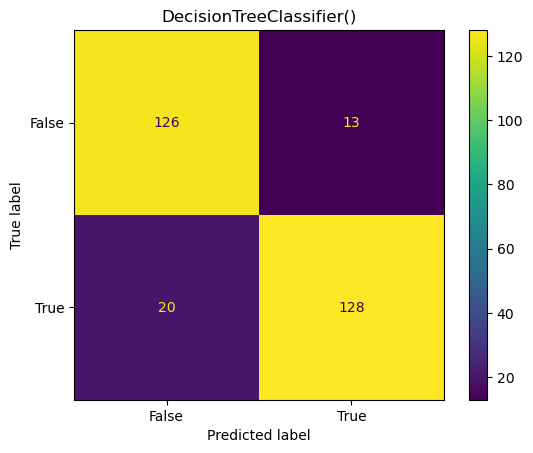

DecisionTreeClassifier        : 0.8850174216027874
RandomForestClassifier()


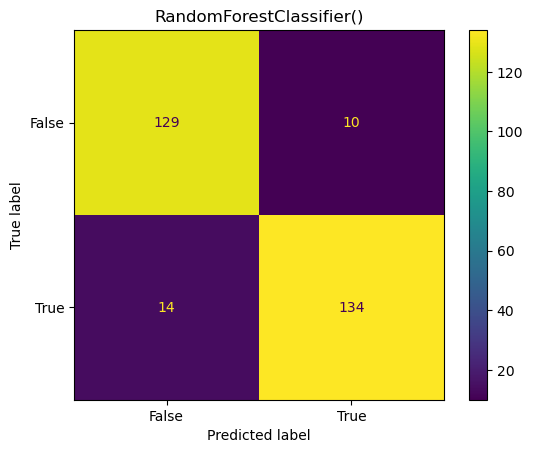

RandomForestClassifier        : 0.9163763066202091
SVC()


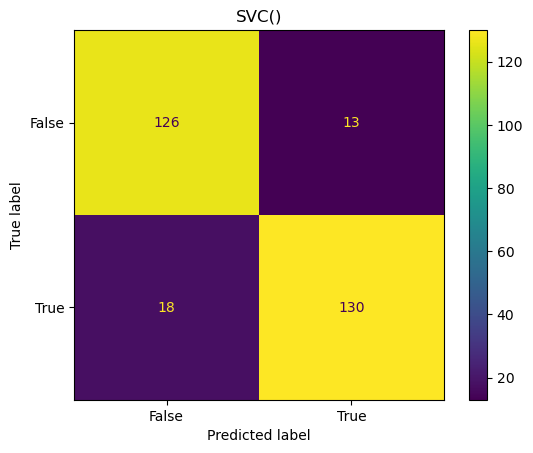

SVC                           : 0.89198606271777
KNeighborsClassifier()


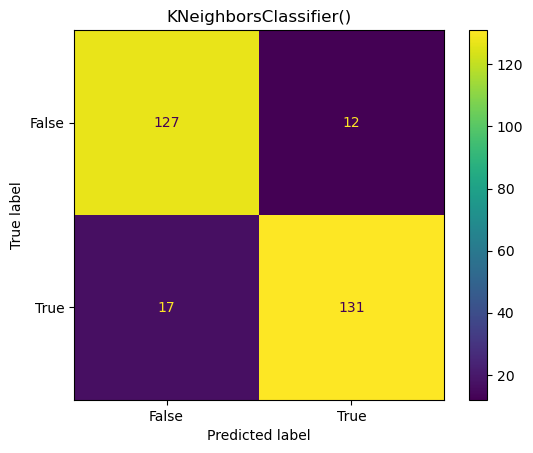

KNeighborsClassifier          : 0.8989547038327527
LinearSVC()


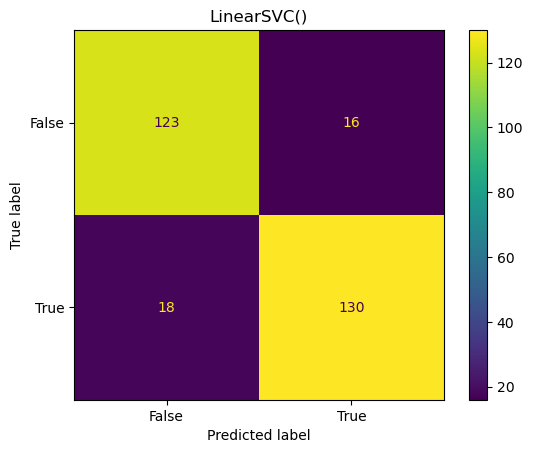

LinearSVC                     : 0.8815331010452961
9/9 [==============================] - 0s 3ms/step


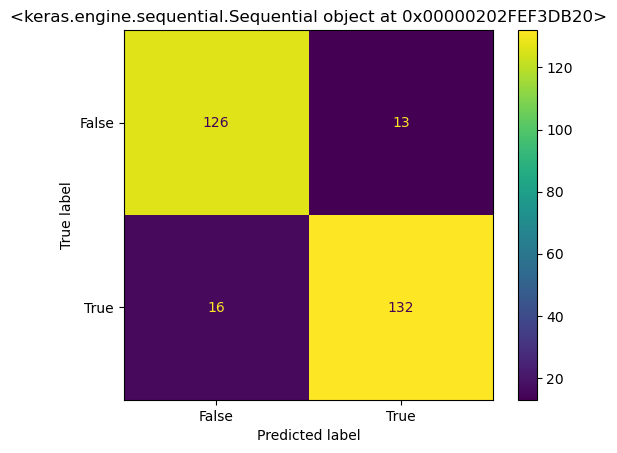

Sequential                    : 0.8989547038327527


In [58]:
for model in trained_all:
    predictions, accuracy = calc_accuracy(trained_all[model]['model'], x_test, y_test, show_confusion_matrix=True)
    print(f"{model:30s}: {accuracy}")
    

In [59]:
model_files = []
for model in trained_all:
    if model != "Sequential":
        pickle.dump(trained_all[model]['model'], open(f"{nvpair_models_dir}/{model}.pickle", "wb"))
        model_files.append(model)
trained_all['Sequential']['model'].save(f'{nvpair_models_dir}/Sequential')

INFO:tensorflow:Assets written to: personification/save_nvpair_models//Sequential\assets


In [60]:
nv_models = {model: pickle.load(open(f"{nvpair_models_dir}/{model}.pickle", "rb")) for model in [fname.replace('.pickle', '') for fname in os.listdir(f'{nvpair_models_dir}') if os.path.isfile(os.path.join(f"{nvpair_models_dir}", fname))]}
nv_models['Sequential'] = keras.models.load_model(f"{nvpair_models_dir}/Sequential")

DecisionTreeClassifier()


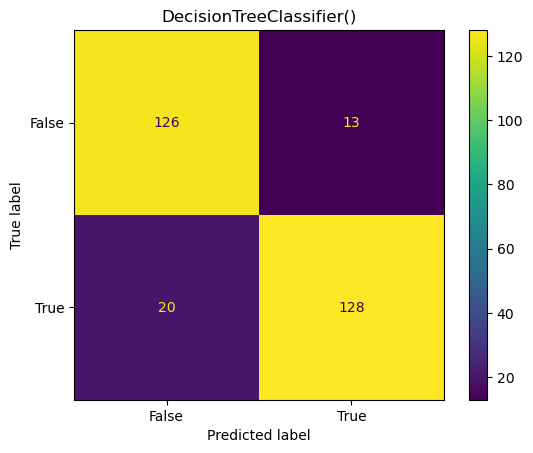

DecisionTreeClassifier        : 0.8850174216027874
RandomForestClassifier()


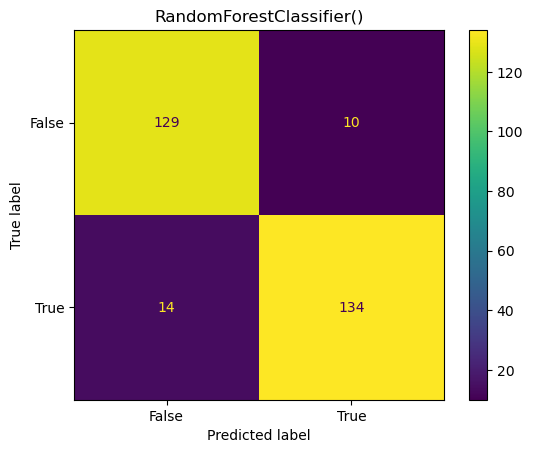

RandomForestClassifier        : 0.9163763066202091
SVC()


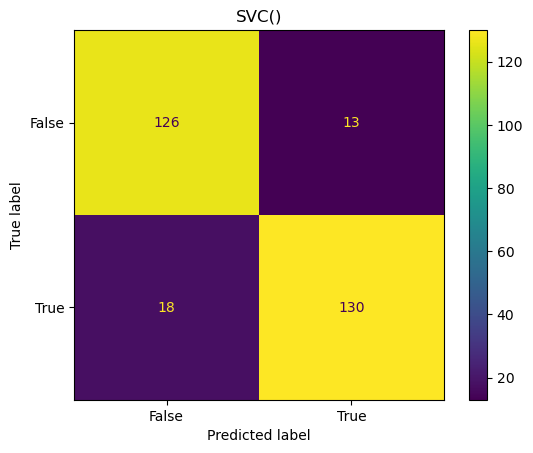

SVC                           : 0.89198606271777
KNeighborsClassifier()


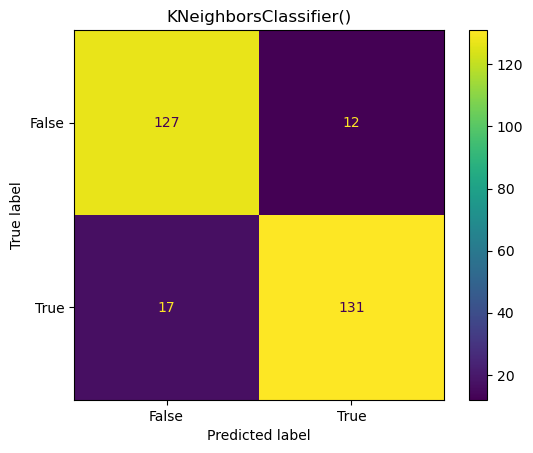

KNeighborsClassifier          : 0.8989547038327527
LinearSVC()


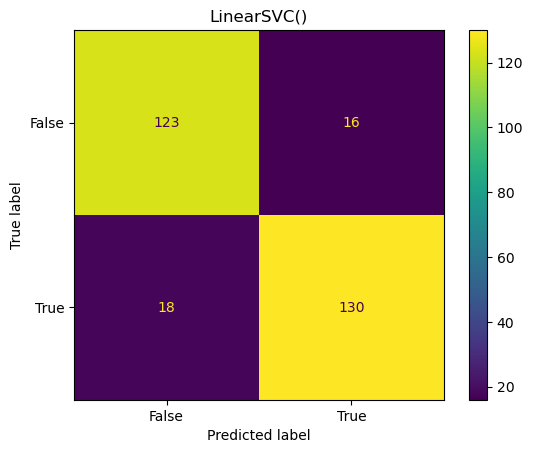

LinearSVC                     : 0.8815331010452961
9/9 [==============================] - 0s 3ms/step


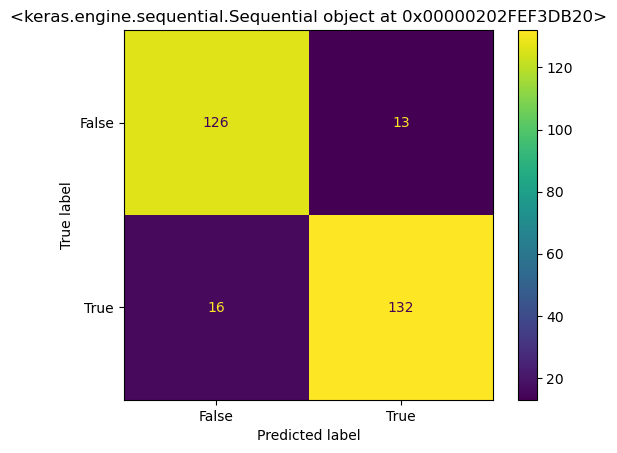

Sequential                    : 0.8989547038327527
9/9 [==============================] - 0s 3ms/step
Ensemble - Mix of all models - 0.9059233449477352


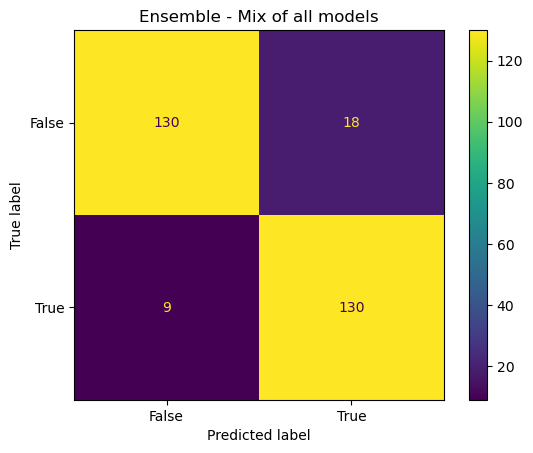

In [61]:
for model in trained_all:
    predictions, accuracy = calc_accuracy(trained_all[model]['model'], x_test, y_test, show_confusion_matrix = True)
    print(f"{model:30s}: {accuracy}")

predictor = ensemble_classification_predictor([model['model'] for model in trained_all.values()])
predictions = predictor.predict(x_test)
actual = np.array(y_test).flatten()
predictions = np.array(predictions).flatten()
results = predictions == actual
count_right = list(results).count(True)
print(f"Ensemble - Mix of all models - {count_right/len(predictions)}")
plot_confusion_matrix("Ensemble - Mix of all models", predictions, y_test)
    

In [62]:
class nv_pair:
    def __init__(self, models_dir = nvpair_models_dir, discard_animate_inanimate = False, discard_nvpair = False):
        self.noun_vector_order = [
                "artifact", "person", "animal", "act", 
                "communication", "substance", "object", 
                "group", "food", "quantity", "cognition", 
                "attribute", "body", "event", "location", 
                "state", "shape", "plant", "possession", 
                "phenomenon", "time", "Tops", "process", 
                "relation", "feeling", "motive"
            ]
        
        self.verb_vector_order = [
            'motion', 'contact', 'communication', 
            'stative', 'change', 'perception', 
            'social', 'body', 'all', 'creation', 
            'possession', 'competition', 'cognition', 
            'act', 'consumption', 'emotion', 'weather', 
            'artifact', 'ppl', 'plant', 'attribute', 
            'group', 'event', 'location', 'shape', 'substance'
            ]
        
        self.noun_vector_size = 40
        self.verb_vector_size = 40
        self.nv_models = {model: pickle.load(open(f"{models_dir}/{model}.pickle", "rb")) for model in [fname.replace('.pickle', '') for fname in os.listdir(models_dir) if os.path.isfile(os.path.join(models_dir, fname))]}
        self.nv_models['Sequential'] = keras.models.load_model(f"{models_dir}/Sequential")
        self.discard_animate_inanimate = discard_animate_inanimate
        self.discard_nvpair = discard_nvpair

        
    def _get_lextypes(self, word, noun = True):
        '''
        Function to get the different types of the word
        
        Gives noun types only by default
        '''
        synsets = wn.synsets(str(word))
        lextypes = []
        if noun:
            for synset in synsets:
                lexname = synset.lexname()
                pos, word_type = lexname.split(".")
                if pos == 'noun':
                    lextypes.append(word_type)
        else:
            for synset in synsets:
                lexname = synset.lexname()
                pos, word_type = lexname.split(".")
                lextypes.append(word_type)
        return set(lextypes)
    
    def get_noun_lextypes(self, word):
        return self._get_lextypes(word)
    
    def get_verb_lextypes(self, word):
        return self._get_lextypes(word, False)
    
    def get_noun_vector_string(self, noun):
        noun_types = set(self._get_lextypes(noun))
        resultant_vector = [
            1 if ltype in noun_types else 0
                for ltype in self.noun_vector_order
            ]
        return resultant_vector

    def get_verb_vector_string(self, verb):
        verb_types = set(self._get_lextypes(verb))
        resultant_vector = [
            1 if ltype in verb_types else 0
                for ltype in self.verb_vector_order
            ]
        return resultant_vector
        
    def get_noun_vector(self, strings):
        return [
            self.get_noun_vector_string(string) for string in strings
        ]
    
    def get_verb_vector(self, strings):
        return [
            self.get_verb_vector_string(string) for string in strings
        ]
    
    def get_nv_pair(self, tup):
        sent = str(tup[0])
        doc = nlp(sent)

        start = tup[0].i
        end = start + len(doc)
        verb = tup[1].i

        head_token = []
        for token in doc:
            if token.head == token:
                head_token.append(token)
        head_token = head_token[0]
        # print(tup, str(head_token), str(tup[1]))
        nvs = self.get_noun_vector_string(str(head_token))
        vvs = self.get_verb_vector_string(str(tup[1]))
        return str(head_token), str(tup[1]), nvs, vvs
    
    def predict_ensemble(self, predictions):
        true_count = 0
        for prediction in predictions:
            if prediction:
                true_count += 1
        if (true_count/len(predictions)) > 0.5:
            return True
        else:
            return False
        
    def fix_predictions(self, predictions):
        '''
        if values are in range 0 to 1 - shifts to True or False
        '''
        predictions = np.array(predictions)
        fixer = np.vectorize(lambda num: True if (num == True or num > 0.5) else False)
        predictions = fixer(predictions)
        return predictions
    
    def get_vector(self, tup):
        ntext, vtext, nvec, vvec = self.get_nv_pair(tup)
        fvec = nvec[:self.noun_vector_size] + vvec[:self.verb_vector_size]
        return fvec
    
    def is_nvpair(self, sentences):
        '''
        Function - returns personification exists or not in sentences
        '''
        if type(sentences) != list and type(sentences) != tuple:
            sentences = [sentences]
        X_predict = sentences
        X_pairs_predict = list(personification.extract_pairs(X_predict))
        store_nv_vectors = []

        for i, pairs in tqdm.tqdm(enumerate(X_pairs_predict), total= len(X_pairs_predict)):
            stemp = []
            for pair in pairs:
                nvv = self.get_vector(pair)
                # print(nvv)
                stemp.append(nvv)
            store_nv_vectors.append(stemp)
        # print(store_nv_vectors)
        indices = [num for num in range(len(store_nv_vectors)) if len(store_nv_vectors[num]) > 0]
        final_nv_vectors = [store_nv_vectors[num][0] for num in indices]
        # print(final_nv_vectors)
        predictions = []
        for model in self.nv_models:
            predictions.append(self.nv_models[model].predict(final_nv_vectors))
        for num in range(len(predictions)):
            predictions[num] = self.fix_predictions(predictions[num])
        predictions_from_models = []
        for num in range(len(predictions[0])):
            predictions_from_models.append([arr[num] for arr in predictions])
        predictions_final = [
            self.predict_ensemble(row) for row in predictions_from_models
        ]
        return X_pairs_predict, predictions_final, indices
    
    def final_prediction(self, sentences):
        if type(sentences) != list and type(sentences) != tuple:
            sentences = [sentences]
        nlp_res, nv_pair, indices = self.is_nvpair(sentences)
        nvpair_matches = []
        for nvpair_res, ind in zip(nv_pair, indices):
            if nvpair_res or self.discard_nvpair:
                nvpair_matches.append(ind)
        pers = personification.get_personifications(sentences)
        # for per in pers:
        #     print(per[0])
        final_predictions = []
        for match in nvpair_matches:
            if len(pers[match]) > 0:
                if pers[match][0][1] or self.discard_animate_inanimate:
                    final_predictions.append(match)
        return final_predictions

mynvp = nv_pair()

In [63]:
inps_np = [line.strip() for line in open("personification/np.txt").readlines()]
inps_p = [line.strip() for line in open("personification/p.txt").readlines()]

In [64]:
mynvp_with_animate_inanimate = nv_pair()
mynvp_without_animate_inanimate = nv_pair(discard_animate_inanimate = True)
mynvp_without_nvpair = nv_pair(discard_nvpair = True)

100%|██████████| 796/796 [00:02<00:00, 390.04it/s]


24/24 [==============================] - 0s 4ms/step


100%|██████████| 1195/1195 [00:03<00:00, 380.62it/s]


25/25 [==============================] - 0s 3ms/step
Inanimate + Matched Noun-Verb pairs - Accuracy: 0.7930688096433953


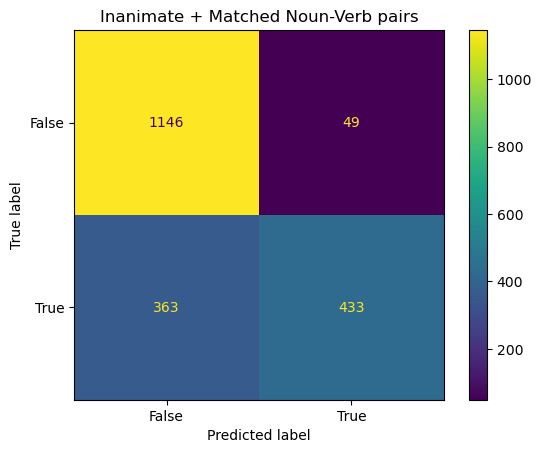

[('precision:', 0.8983402489626556), ('recall:', 0.5439698492462312), ('accuracy:', 0.7930688096433953), ('f1_score:', 0.6776212832550861)]


(0.8983402489626556,
 0.5439698492462312,
 0.7930688096433953,
 0.6776212832550861)

In [65]:
res_final_p = set(mynvp_with_animate_inanimate.final_prediction(inps_p))
res_final_np = set(mynvp_with_animate_inanimate.final_prediction(inps_np))
stats_p = [1 if num in res_final_p else 0 for num in range(len(inps_p))]
stats_np = [1 if num in res_final_np else 0 for num in range(len(inps_np))]
exp_p = [1 for _ in range(len(inps_p))]
exp_np = [0 for _ in range(len(inps_np))]
stats_all = stats_p + stats_np
exp_all = exp_p + exp_np
stats_all = np.array(stats_all)
exp_all = np.array(exp_all)
len(stats_all), len(exp_all)
results = stats_all == exp_all
results = list(results)
print(f"Inanimate + Matched Noun-Verb pairs - Accuracy: {results.count(True) / len(results)}")
plot_confusion_matrix("Inanimate + Matched Noun-Verb pairs", exp_all, stats_all)
precision_recall_accuracy_f1(exp_all, stats_all)

100%|██████████| 796/796 [00:02<00:00, 368.24it/s]


24/24 [==============================] - 0s 3ms/step


100%|██████████| 1195/1195 [00:03<00:00, 372.08it/s]


25/25 [==============================] - 0s 3ms/step
Noun-Verb pairs ONLY - Accuracy: 0.8533400301356102


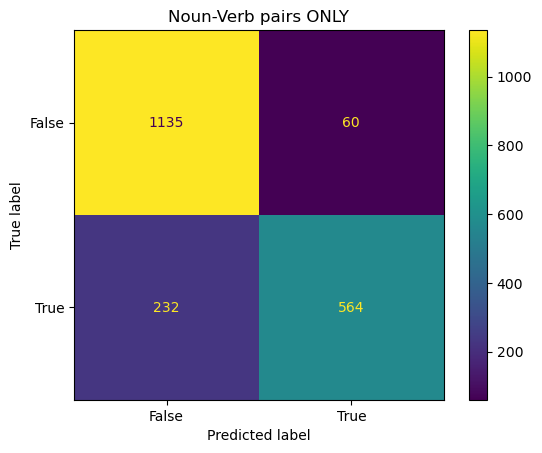

[('precision:', 0.9038461538461539), ('recall:', 0.7085427135678392), ('accuracy:', 0.8533400301356102), ('f1_score:', 0.7943661971830985)]


(0.9038461538461539,
 0.7085427135678392,
 0.8533400301356102,
 0.7943661971830985)

In [68]:
res_final_p = set(mynvp_without_animate_inanimate.final_prediction(inps_p))
res_final_np = set(mynvp_without_animate_inanimate.final_prediction(inps_np))
stats_p = [1 if num in res_final_p else 0 for num in range(len(inps_p))]
stats_np = [1 if num in res_final_np else 0 for num in range(len(inps_np))]
exp_p = [1 for _ in range(len(inps_p))]
exp_np = [0 for _ in range(len(inps_np))]
stats_all = stats_p + stats_np
exp_all = exp_p + exp_np
stats_all = np.array(stats_all)
exp_all = np.array(exp_all)
len(stats_all), len(exp_all)
results = stats_all == exp_all
results = list(results)
print(f"Noun-Verb pairs ONLY - Accuracy: {results.count(True) / len(results)}")
plot_confusion_matrix("Noun-Verb pairs ONLY", exp_all, stats_all)
precision_recall_accuracy_f1(exp_all, stats_all)

100%|██████████| 796/796 [00:02<00:00, 381.56it/s]


24/24 [==============================] - 0s 4ms/step


100%|██████████| 1195/1195 [00:03<00:00, 329.12it/s]


25/25 [==============================] - 0s 5ms/step
Inanimate Pairs ONLY - Accuracy: 0.5394274234053239


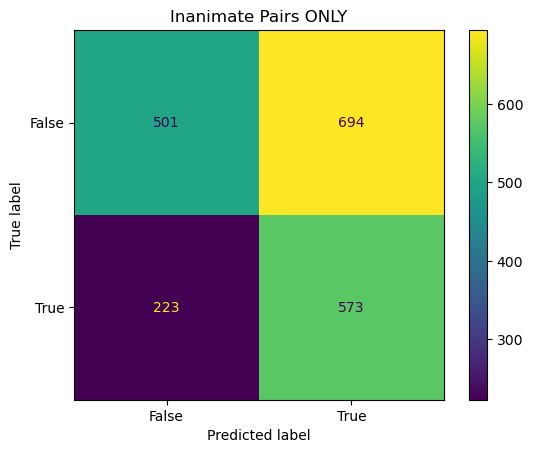

[('precision:', 0.452249408050513), ('recall:', 0.7198492462311558), ('accuracy:', 0.5394274234053239), ('f1_score:', 0.5555016965584101)]


(0.452249408050513, 0.7198492462311558, 0.5394274234053239, 0.5555016965584101)

In [69]:
res_final_p = set(mynvp_without_nvpair.final_prediction(inps_p))
res_final_np = set(mynvp_without_nvpair.final_prediction(inps_np))
stats_p = [1 if num in res_final_p else 0 for num in range(len(inps_p))]
stats_np = [1 if num in res_final_np else 0 for num in range(len(inps_np))]
exp_p = [1 for _ in range(len(inps_p))]
exp_np = [0 for _ in range(len(inps_np))]
stats_all = stats_p + stats_np
exp_all = exp_p + exp_np
stats_all = np.array(stats_all)
exp_all = np.array(exp_all)
len(stats_all), len(exp_all)
results = stats_all == exp_all
results = list(results)
print(f"Inanimate Pairs ONLY - Accuracy: {results.count(True) / len(results)}")
plot_confusion_matrix("Inanimate Pairs ONLY", exp_all, stats_all)
precision_recall_accuracy_f1(exp_all, stats_all)

In [70]:
def predict(inputs, discard_animate_inanimate = True, discard_nvpair = False):
    mynvp_temp = nv_pair(discard_animate_inanimate = discard_animate_inanimate, discard_nvpair = discard_nvpair)
    predictions = set(mynvp_temp.final_prediction(inputs))
    return [inputs[i] for i in range(len(inputs)) if i in predictions]

In [73]:
inputs = '''The light in the room was dim and needed to be brightened.
The pavement was cracked and uneven.
The door handle turned easily, allowing me to enter the room.
The bike tire hissed as I pumped it up with air.
The road was long and winding.
The broom swept up the dust and dirt.
The scissors cut the paper in a straight line.
The car drove down the winding road.
The stars twinkled in the night sky.
The pillow was soft and comfortable to sleep on.
The leaves rustled and chattered in the autumn breeze.
The flowers smiled up at the sun.
The stars winked at us from the sky.
The river sang a melody of its own, like a master musician.
The ocean roared like a ferocious beast, hungry for its prey.
The leaves rustled like a whispered secret in the wind.
The stars winked and blinked at us, like mischievous children.
The snow crunched under my boots.
The trees swayed in the breeze like dancers, moving to the rhythm of the wind.
The trees bowed their heads in respect for the passing storm.
The trees stretched towards the sun, like worshippers reaching for their deity.
The clouds hung low in the sky, like a heavy burden weighing us down.
The stars sang a song of wonder, like a celestial choir.
The ocean ebbed and flowed, like a living thing.
The stars twinkled like diamonds.
The flowers danced in the gentle breeze.
The flowers danced in the breeze.
The sun hid behind the clouds.
The lightning slashed the sky like a sword.
The raindrops danced on the pavement.'''
inputs = inputs.split("\n")
results = predict(inputs)
for line in results:
    print(line)

100%|██████████| 30/30 [00:00<00:00, 251.50it/s]


1/1 [==============================] - 0s 44ms/step
The leaves rustled and chattered in the autumn breeze.
The flowers smiled up at the sun.
The ocean roared like a ferocious beast, hungry for its prey.
The leaves rustled like a whispered secret in the wind.
The stars winked and blinked at us, like mischievous children.
The trees bowed their heads in respect for the passing storm.
The trees stretched towards the sun, like worshippers reaching for their deity.
The clouds hung low in the sky, like a heavy burden weighing us down.
The stars sang a song of wonder, like a celestial choir.
The ocean ebbed and flowed, like a living thing.
The flowers danced in the gentle breeze.
The flowers danced in the breeze.
The sun hid behind the clouds.
The lightning slashed the sky like a sword.
The raindrops danced on the pavement.
